# AeroPredict: Transformer Based Real-Time Flight Delay Predictor

## 0. Environment Settings

In [3]:
# !/usr/bin/env python3
# necessary imports
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

In [25]:
# Set random seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 1. Data Processing

In [6]:
# Load the extracted raw flight data
raw_data = pd.read_csv("raw_flights_data_10k.csv")

# Display basic information about the dataset
print(raw_data.head())
print(raw_data.info())

   O_TEMP  O_PRCP  O_WSPD  D_TEMP  D_PRCP  D_WSPD  O_LATITUDE  O_LONGITUDE  \
0    10.0     0.0    20.5     5.6     0.0    22.3    40.63975    -73.77893   
1    27.2     0.0    14.8    15.6     0.0    14.8    30.49406    -81.68786   
2     7.8     0.0     0.0    -6.7     0.0    38.9    30.49406    -81.68786   
3    13.9     0.0     5.4     6.7     0.0    24.1    40.77724    -73.87261   
4     7.8     2.2     9.4     7.8     0.0    27.7    40.77724    -73.87261   

   D_LATITUDE  D_LONGITUDE  DEP_DELAY ORIGIN DEST         CRS_DEP_TIME  \
0    42.21206    -83.34884       -5.0    JFK  DTW  2024-04-24 07:25:00   
1    42.21206    -83.34884       13.0    JAX  DTW  2024-05-29 11:59:00   
2    42.21206    -83.34884       -4.0    JAX  DTW  2024-12-05 11:45:00   
3    42.21206    -83.34884       -7.0    LGA  DTW  2024-02-10 17:00:00   
4    42.21206    -83.34884       -7.0    LGA  DTW  2024-04-02 17:49:00   

          CRS_ARR_TIME  
0  2024-04-24 09:29:00  
1  2024-05-29 14:18:00  
2  2024-12-

In [7]:
#
ALL_NUMERICAL_COLS = [
    'O_TEMP', 'O_PRCP', 'O_WSPD', 'D_TEMP', 'D_PRCP', 'D_WSPD', 'O_LATITUDE', 'O_LONGITUDE', 'D_LATITUDE', 'D_LONGITUDE'
]

ALL_CATEGORICAL_COLS = [
    'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'CRS_ARR_TIME'
]

def preprocess_data(df):
    df_clean = df.copy()
    
    for col in ALL_NUMERICAL_COLS:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())
    for col in ALL_CATEGORICAL_COLS:
        df_clean[col] = df_clean[col].fillna('Unknown')

    label_encoders = {}
    for col in ALL_CATEGORICAL_COLS:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
        label_encoders[col] = le
        
    cat_dims = [len(le.classes_) for col, le in label_encoders.items()]
    
    scaler_X = StandardScaler()
    df_clean[ALL_NUMERICAL_COLS] = scaler_X.fit_transform(df_clean[ALL_NUMERICAL_COLS])
    
    X_num = df_clean[ALL_NUMERICAL_COLS].values
    X_cat = df_clean[ALL_CATEGORICAL_COLS].values
    
    df_clean['is_delayed'] = ((df_clean['DEP_DELAY'] >= 0)).astype(int)
    y_cls = df_clean['is_delayed'].values
    y_reg = df_clean['DEP_DELAY'].values
    
    return X_num, X_cat, y_cls, y_reg, cat_dims, scaler_X, label_encoders

# Preprocess the data
X_num, X_cat, y_cls, y_reg, cat_dims, scaler_X, le_dict = preprocess_data(raw_data)

scaler_y = StandardScaler()
y_reg_scaled = scaler_y.fit_transform(y_reg.reshape(-1, 1)).flatten()

# Split the data into training and testing sets
X_num_train, X_num_test, X_cat_train, X_cat_test, y_cls_train, y_cls_test, y_reg_train, y_reg_test = train_test_split(
    X_num, X_cat, y_cls, y_reg_scaled, test_size=0.1, random_state=42, stratify=y_cls
)

# Quick stats
print(sum(y_cls_train))

print(f"Features ready. Num: {len(ALL_NUMERICAL_COLS)}, Cat: {len(ALL_CATEGORICAL_COLS)}")
print(f"Train size: {X_num_train.shape[0]}, Test size: {X_num_test.shape[0]}")

3742
Features ready. Num: 10, Cat: 4
Train size: 9000, Test size: 1000


In [57]:
class AeroPredictDataset(Dataset):
    def __init__(self, X_num, X_cat, y_cls, y_reg):
        self.X_num = torch.FloatTensor(X_num)
        self.X_cat = torch.LongTensor(X_cat)
        self.y_cls = torch.FloatTensor(y_cls).unsqueeze(1) 
        self.y_reg = torch.FloatTensor(y_reg).unsqueeze(1)

    def __len__(self):
        return len(self.y_cls)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y_cls[idx], self.y_reg[idx]

# Create datasets and dataloaders
train_dataset = AeroPredictDataset(X_num_train, X_cat_train, y_cls_train, y_reg_train)
test_dataset = AeroPredictDataset(X_num_test, X_cat_test, y_cls_test, y_reg_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(train_dataset[0])

(tensor([-1.7752, -0.1162,  0.7662,  1.2619, -0.1260,  1.1343,  0.5351, -0.5094,
        -1.1070, -0.0067]), tensor([  68,  121, 2084, 2126]), tensor([1.]), tensor([0.2590]))


## 2. Model Training

In [ ]:
# Define the Transformer-based model
class AeroPredictTransformer(nn.Module):
    def __init__(self, num_numerical, cat_dims, d_model=64, nhead=4, num_layers=2, dropout=0.05):
        super(AeroPredictTransformer, self).__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(num_cats, d_model) for num_cats in cat_dims])
        self.num_projection = nn.Linear(1, d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=256, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        total_input_dim = (len(cat_dims) + num_numerical) * d_model
        
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_input_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 1)
        )
        self.regressor_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(total_input_dim, 256),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x_num, x_cat):
        cat_embeddings = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat_emb = torch.stack(cat_embeddings, dim=1)
        x_num_emb = self.num_projection(x_num.unsqueeze(-1))
        x_input = torch.cat([x_cat_emb, x_num_emb], dim=1)
        x_shared = self.transformer_encoder(x_input)
        return self.classifier_head(x_shared), self.regressor_head(x_shared)

In [77]:
# Initialize the model, loss functions, optimizer, and scheduler
model = AeroPredictTransformer(
    num_numerical=X_num.shape[1],
    cat_dims=cat_dims,
    d_model=64,
    nhead=4,
    num_layers=2,
    dropout=0.2
).to(device)

print(model)

total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

criterion_cls = nn.BCEWithLogitsLoss()
criterion_reg = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Training Loop
def train_mtl_model(model, train_loader, val_loader, epochs=10, cls_weight=1.0, reg_weight=0):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x_num, x_cat, y_cls, y_reg in train_loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            y_cls, y_reg = y_cls.to(device), y_reg.to(device)

            optimizer.zero_grad()

            # Forward pass
            pred_cls, pred_reg = model(x_num, x_cat)

            # Calculate Losses
            loss_cls = criterion_cls(pred_cls, y_cls)
            loss_reg = criterion_reg(pred_reg, y_reg)

            # Combine Losses
            loss = (cls_weight * loss_cls) + (reg_weight * loss_reg)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_num.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_num, x_cat, y_cls, y_reg in val_loader:
                x_num, x_cat = x_num.to(device), x_cat.to(device)
                y_cls, y_reg = y_cls.to(device), y_reg.to(device)
                pred_cls, pred_reg = model(x_num, x_cat)
                loss_cls = criterion_cls(pred_cls, y_cls)
                loss_reg = criterion_reg(pred_reg, y_reg)
                loss = (cls_weight * loss_cls) + (reg_weight * loss_reg)
                val_loss += loss.item() * x_num.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Step Scheduler
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    return train_losses, val_losses

print("Starting training...")
train_hist, val_hist = train_mtl_model(model, train_loader, test_loader, epochs=4, cls_weight=0.1, reg_weight=1)

AeroPredictTransformer(
  (embeddings): ModuleList(
    (0): Embedding(253, 64)
    (1): Embedding(266, 64)
    (2): Embedding(9606, 64)
    (3): Embedding(9800, 64)
  )
  (num_projection): Linear(in_features=1, out_features=64, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (classifier_head): Sequential(
    (0): Flatten

(0.0, 1.1214427473280166)

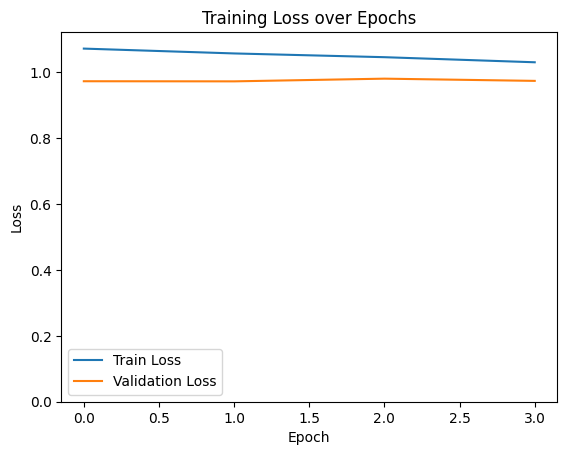

In [78]:
# Plot training and validation loss
plt.plot(train_hist, label='Train Loss')
plt.plot(val_hist, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.ylim(0, max(train_hist) + 0.05)

## 3. Evaluation

In [80]:
# Evaluate the model
def evaluate_model(model, loader, scaler_y):
    model.eval()
    
    preds_cls_prob = []
    preds_reg_val = []
    targets_cls = []
    targets_reg = []
    
    with torch.no_grad():
        for x_num, x_cat, y_cls, y_reg in loader:
            x_num, x_cat = x_num.to(device), x_cat.to(device)
            
            out_cls, out_reg = model(x_num, x_cat)
            
            probs = torch.sigmoid(out_cls).cpu().numpy()
            preds_cls_prob.extend(probs)
            targets_cls.extend(y_cls.numpy())
            
            preds_reg_val.extend(out_reg.cpu().numpy())
            targets_reg.extend(y_reg.numpy())
            
    preds_cls_prob = np.array(preds_cls_prob).flatten()
    preds_cls_bin = (preds_cls_prob > 0.5).astype(int)
    targets_cls = np.array(targets_cls).flatten()
    
    preds_reg_minutes = scaler_y.inverse_transform(np.array(preds_reg_val).reshape(-1, 1)).flatten()
    targets_reg_minutes = scaler_y.inverse_transform(np.array(targets_reg).reshape(-1, 1)).flatten()
    
    print(f"\n=== Transformer Evaluation (Full Features) ===")
    print(f"Accuracy : {accuracy_score(targets_cls, preds_cls_bin):.4f}")
    print(f"ROC AUC  : {roc_auc_score(targets_cls, preds_cls_prob):.4f}")
    print(f"MAE      : {mean_absolute_error(targets_reg_minutes, preds_reg_minutes):.2f} min")
    
    return targets_reg_minutes, preds_reg_minutes

targets, preds_nn = evaluate_model(model, test_loader, scaler_y)


=== Transformer Evaluation (Full Features) ===
Accuracy : 0.6190
ROC AUC  : 0.6269
MAE      : 27.19 min


## 4. Baseline Comparison

In [81]:
# Evaluate Baseline Models (RF & GBM)
# --- 1. Prepare Data ---
X_train_sk = np.hstack([X_num_train, X_cat_train])
X_test_sk = np.hstack([X_num_test, X_cat_test])

print(f"Baseline Data Ready. Shape: {X_test_sk.shape}")

# --- 2. Random Forest ---
print("\n=== Baseline 1: Random Forest (Full Features) ===")
# Classification
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
rf_clf.fit(X_train_sk, y_cls_train)
rf_cls_preds = rf_clf.predict(X_test_sk)
print(f"Accuracy : {accuracy_score(y_cls_test, rf_cls_preds):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_cls_test, rf_clf.predict_proba(X_test_sk)[:,1]):.4f}")

# Regression
rf_reg = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_sk, y_reg_train) 
rf_reg_preds_scaled = rf_reg.predict(X_test_sk)
rf_preds_minutes = scaler_y.inverse_transform(rf_reg_preds_scaled.reshape(-1, 1)).flatten()
rf_targets_minutes = scaler_y.inverse_transform(y_reg_test.reshape(-1, 1)).flatten()
print(f"MAE      : {mean_absolute_error(rf_targets_minutes, rf_preds_minutes):.2f} min")


# --- 3. Gradient Boosting Machine (GBM) ---
print("\n=== Baseline 2: Gradient Boosting (Full Features) ===")
# Classification
gb_clf = GradientBoostingClassifier(n_estimators=10, max_depth=5, random_state=42)
gb_clf.fit(X_train_sk, y_cls_train)
gb_cls_preds = gb_clf.predict(X_test_sk)
print(f"Accuracy : {accuracy_score(y_cls_test, gb_cls_preds):.4f}")
print(f"ROC AUC  : {roc_auc_score(y_cls_test, gb_clf.predict_proba(X_test_sk)[:,1]):.4f}")

# Regression
gb_reg = GradientBoostingRegressor(n_estimators=10, max_depth=5, random_state=42)
gb_reg.fit(X_train_sk, y_reg_train) 
gb_reg_preds_scaled = gb_reg.predict(X_test_sk)
gb_preds_minutes = scaler_y.inverse_transform(gb_reg_preds_scaled.reshape(-1, 1)).flatten()
print(f"MAE      : {mean_absolute_error(rf_targets_minutes, gb_preds_minutes):.2f} min")

Baseline Data Ready. Shape: (1000, 14)

=== Baseline 1: Random Forest (Full Features) ===
Accuracy : 0.6120
ROC AUC  : 0.6193
MAE      : 28.15 min

=== Baseline 2: Gradient Boosting (Full Features) ===
Accuracy : 0.6140
ROC AUC  : 0.6298
MAE      : 27.29 min
